In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
try:
    from utils import find_repo_root, load_dict, calculate_vectorized_correlation, get_fmri, get_pca, correlation_metric, download_fmri
except:
    from utils_without_motion import find_repo_root, calculate_vectorized_correlation, get_fmri, get_pca
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

### Function Definitions

In [ ]:
# Dense Layer
def train_model(X_train, X_val, y_train, y_val,  hpo, param_grid, num_epochs = 100, visualize_results = True):
    """
    conducts the training for a particular input layer of the CNN, subject & ROI. saves model.
    :param X_train: training data (feature map PCs from first 800 videos from a particular layer)
    :param X_val: validation data (feature map PCs from videos 801-900 from a particular layer)
    :param y_train: training labels (scans for first 800 videos for the particular subject & ROI)
    :param y_val: training labels (scans for videos 801-900 for the particular subject & ROI)
    :param num_epochs: number of epochs for training
    :param visualize_results: whether training will be plotted
    :return: model parameters
    """
    print("y_train shape: ", y_train.shape)
    print("Y_val shape: ", y_val.shape)
    
    # specify number of neurons per layer, depending on the number of inputs from a particular layer and number of output voxels
    # leads to symmetric funnel-like shape of the network, with increasing layer sizes for WB and decreasing size for all ROIs
    input_neurons = X_train.shape[1]
    hidden1_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(2/3)
    hidden2_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(1/3)
    output_neurons = y_train.shape[1]
    
    # l2 regularization for all layers
    l2_reg = l2(0.0001)
    
    # model construction: 2 hidden layers. L2 Reg & Dropout.
    model = Sequential([
        Dense(hidden1_neurons, input_shape=(input_neurons,),
              activation='relu', kernel_regularizer=l2_reg),
        Dropout(0.2),
        Dense(hidden2_neurons, activation='relu',
              kernel_regularizer=l2_reg),
        Dropout(0.2),
        Dense(output_neurons, activation='linear',
              kernel_regularizer=l2_reg),
        Dropout(0.2)
    ])
    
    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    

    # Compiling the model
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mean_squared_error')
    
    # Training the model
    history = model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    
    if visualize_results:
        # print layer overview
        print(model.summary())
        
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
    # save the model in a new folder
    models_dir = os.path.join(os.getcwd(), "models", layer, ROI, sub)
    print(models_dir)
    if not os.path.exists(models_dir):
      os.makedirs(models_dir)
    model.save(models_dir + "/model" + ".keras")
    
    return model

In [3]:
# def load_data_and_train(train_pca, val_pca, sub, layer, ROI = 'WB'):
#     
#     # Load fMRI data (labels)
#     if ROI == "WB":
#       track="full_track"
#     else:
#       track="mini_track"
#     fmri_train, fmri_val= get_fmri(ROI, track, sub, mode="val")
#     
#     # model training
#     train_model(train_pca, val_pca, fmri_train, fmri_val)

In [ ]:
# hyperparameter optimization
param_grid ={"learning_rate": [0.0001, 0.00001],
             "num_hidden_layers": [1,2],
             "dropout": [0.2, 0.3, 0.4, 0.5],
             "l2_reg":[0.001, 0.0001, 0.00001]}

# increase? Let early stopping steer training
epochs = [100]

# Questions:
# Dropout:
#   Should I use it on the input & output layer as well?
#   Should the architecture be symmetric, or higher dropout for larger layers?
#       Probably network-specific, not so much layer-specific. Steer via HPO
# L2-Reg:
#       apply to every layer. Steer via HPO
# L1-Reg:
#    for the most important models, we have few inputs, and expect all of them to be relevant. Do
#    not use

### Model Training

Starting ROI:  WB sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 18222)
ROI_val shape:  (100, 18222)
ROI_test shape:  (100, 18222)
y_train shape:  (800, 18222)
Y_val shape:  (100, 18222)
25/25 [==============================] - 29s 993ms/step - loss: 57.5494 - val_loss: 0.2208
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6674)              6013274   
                                                                 
 dense_1 (Dense)             (None, 12448)             83090400  
                                                                 
 dense_2 (Dense)             (None, 18222)             226845678 
                                                                 
Total params: 315949

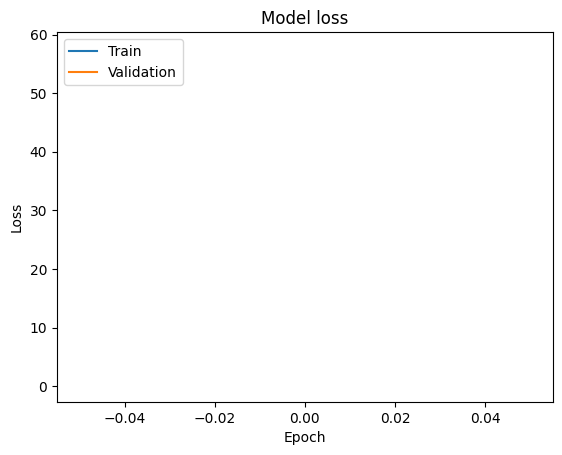

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub01
Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 232)
ROI_val shape:  (100, 232)
ROI_test shape:  (100, 232)
y_train shape:  (800, 232)
Y_val shape:  (100, 232)
25/25 [==============================] - 2s 32ms/step - loss: 123.1544 - val_loss: 0.2561
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 677)               609977    
                                                                 
 dense_4 (Dense)             (None, 454)    

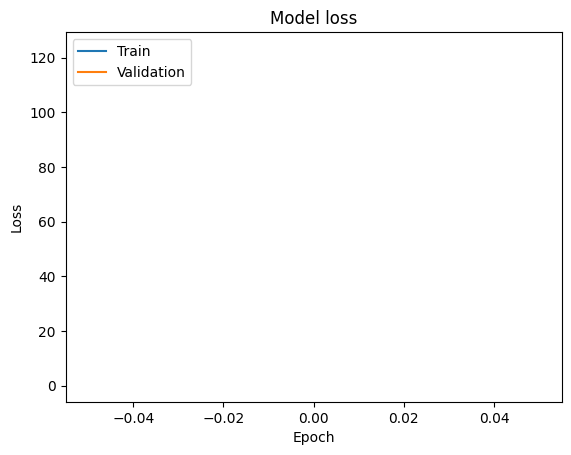

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub01
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 231)
ROI_val shape:  (100, 231)
ROI_test shape:  (100, 231)
y_train shape:  (800, 231)
Y_val shape:  (100, 231)
25/25 [==============================] - 2s 20ms/step - loss: 119.1466 - val_loss: 0.2443
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 677)               609977    
                                                                 
 dense_7 (Dense)             (None, 454)    

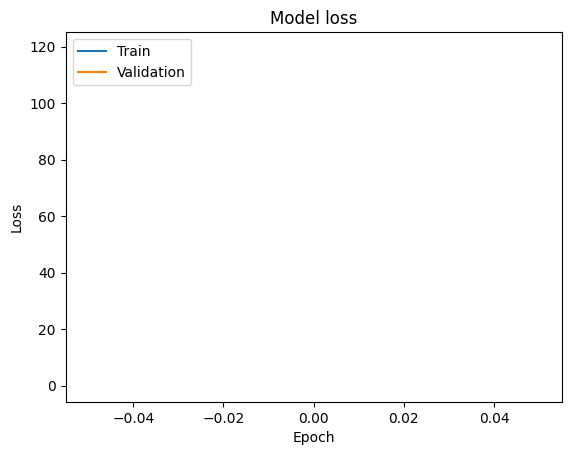

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub01
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 261)
ROI_val shape:  (100, 261)
ROI_test shape:  (100, 261)
y_train shape:  (800, 261)
Y_val shape:  (100, 261)
25/25 [==============================] - 2s 29ms/step - loss: 94.5882 - val_loss: 0.2301
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 687)               618987    
                                                                 
 dense_10 (Dense)            (None, 474)     

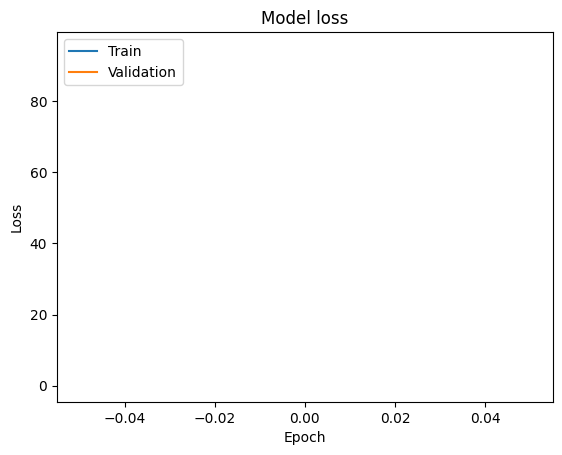

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub01
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 107)
ROI_val shape:  (100, 107)
ROI_test shape:  (100, 107)
y_train shape:  (800, 107)
Y_val shape:  (100, 107)
25/25 [==============================] - 2s 24ms/step - loss: 171.6388 - val_loss: 0.3542
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 635)               572135    
                                                                 
 dense_13 (Dense)            (None, 371)    

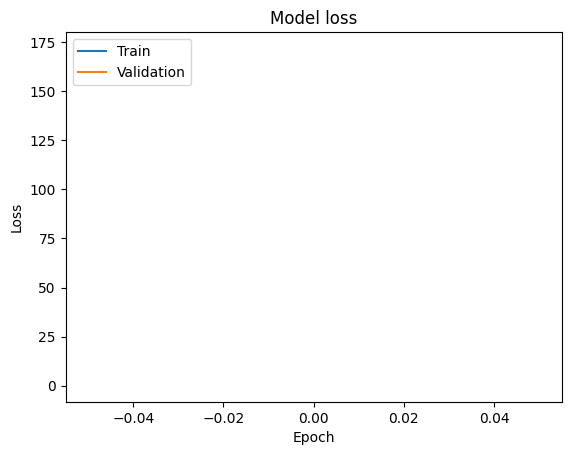

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub01
Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 1843)
ROI_val shape:  (100, 1843)
ROI_test shape:  (100, 1843)
y_train shape:  (800, 1843)
Y_val shape:  (100, 1843)
25/25 [==============================] - 3s 84ms/step - loss: 45.8275 - val_loss: 0.2532
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1214)              1093814   
                                                                 
 dense_16 (Dense)            (None, 152

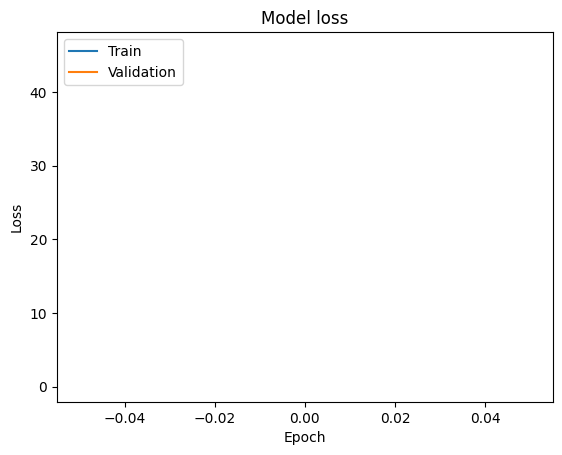

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub01
Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 351)
ROI_val shape:  (100, 351)
ROI_test shape:  (100, 351)
y_train shape:  (800, 351)
Y_val shape:  (100, 351)
25/25 [==============================] - 2s 37ms/step - loss: 82.6152 - val_loss: 0.2544
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 717)               646017    
                                                                 
 dense_19 (Dense)            (None, 534)  

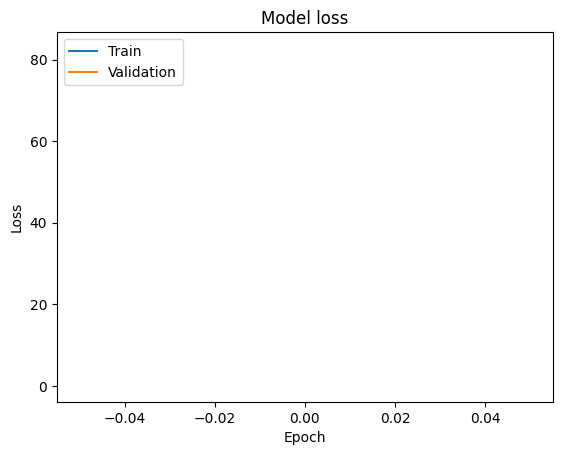

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub01
Completed ROI:  EBA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 68)
ROI_val shape:  (100, 68)
ROI_test shape:  (100, 68)
y_train shape:  (800, 68)
Y_val shape:  (100, 68)
25/25 [==============================] - 2s 20ms/step - loss: 276.0737 - val_loss: 13.6000
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 622)               560422    
                                                                 
 dense_22 (Dense)            (None, 345)     

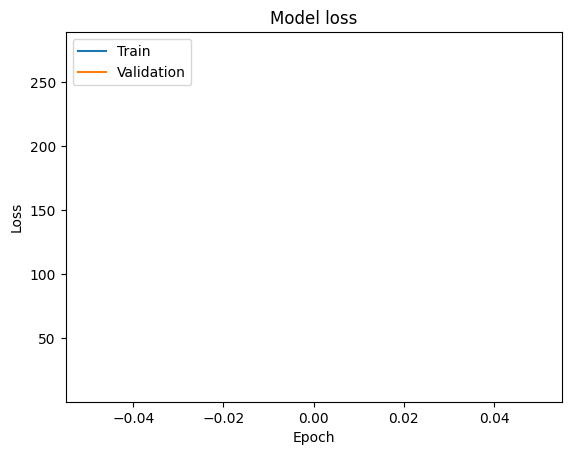

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub01
Completed ROI:  FFA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 341)
ROI_val shape:  (100, 341)
ROI_test shape:  (100, 341)
y_train shape:  (800, 341)
Y_val shape:  (100, 341)
25/25 [==============================] - 1s 14ms/step - loss: 114.5693 - val_loss: 0.2426
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 713)               642413    
                                                                 
 dense_25 (Dense)            (None, 527) 

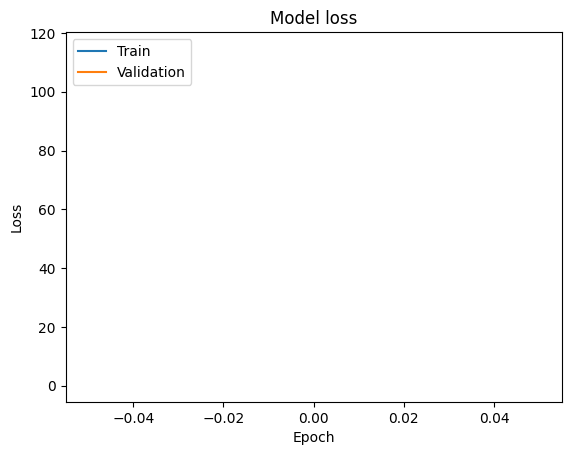

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub01
Completed ROI:  STS sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub01
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 425)
ROI_val shape:  (100, 425)
ROI_test shape:  (100, 425)
y_train shape:  (800, 425)
Y_val shape:  (100, 425)
25/25 [==============================] - 1s 12ms/step - loss: 65.6626 - val_loss: 0.2162
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 741)               667641    
                                                                 
 dense_28 (Dense)            (None, 583)  

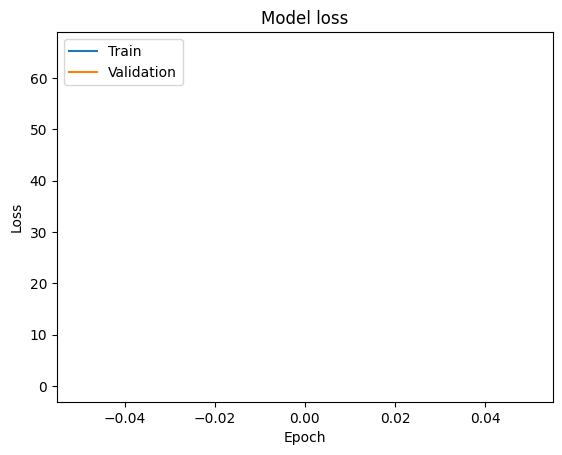

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub01
Completed ROI:  PPA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub02
all_pcas shape:  (5, 30, 30)
all_pcas shape after concatenation:  (1000, 30, 30)
train_pca shape:  (800, 900)
val_pca shape:  (100, 900)
test_pca shape:  (100, 900)
ROI_train shape:  (800, 21573)
ROI_val shape:  (100, 21573)
ROI_test shape:  (100, 21573)
y_train shape:  (800, 21573)
Y_val shape:  (100, 21573)
22/25 [=========================>....] - ETA: 14s - loss: 97.6035 


KeyboardInterrupt



In [4]:
def run_training_pipeline(hpo=False, import_type="direct"):
    """
    conducts training. Models will be saved in .keras format for evaluation.
    Parameters
    ----------
    hpo: if set to true, hyperparameter optimization will be conducted. Otherwise, a single set of hyperparameters will be applied
    import_type: set to "direct" if the full PCA output from the main Resnet is directly loaded into the CWD.
                 set to "indirect" if a folder structure with one file per video is loaded.
    """
    # load one only one main PCA file into the Ucloud session. This will determine the layer
    layer_list = ["stage_1", "stage_2", "stage_3", "stage_4", "stage_5", "final"]
    for i in layer_list:
        if os.path.exists(f"{i}_pca.npy"):
            layer = i
            break

    # filter out subs / ROIs manually in case not everything should be run
    subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
    ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
    
    # unless already downloaded, download the fmri data
    download_fmri()
    
    # Load activations (PCA outputs)
    train_pca,val_pca = get_pca(layer, mode="val", import_type=import_type)
    
    if hpo:
        param_grid ={"learning_rate": [0.0001, 0.00001],
             "num_hidden_layers": [1,2],
             "dropout": [0.2, 0.3, 0.4, 0.5],
             "l2_reg":[0.001, 0.0001, 0.00001]}
        # ToDo: implement HPO. Check if sklearn module can be implemented easily for this
        
        
    for sub in subs:
      for ROI in ROIs:
        print ("Starting ROI: ", ROI, "sub: ",sub)
            # Load fMRI data (labels)
        if ROI == "WB":
          track="full_track"
        else:
          track="mini_track"
        fmri_train, fmri_val= get_fmri(ROI, track, sub, mode="val")
    
        # model training
        # ToDo: add required changes for HPO to model training
        train_model(train_pca, val_pca, fmri_train, fmri_val, hpo, param_grid)
        
        print ("Completed ROI: ", ROI, "sub: ",sub)
        print("----------------------------------------------------------------------------")

In [ ]:
if __name__ == "__main__":
    run_training_pipeline(hpo=False)